In [1]:
import struct
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.utils.data as data_utils
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
import random
from torch.utils.data import DataLoader, ConcatDataset
from typing import Tuple, List

fileFashionTrainName = './datasetFashion/train-images-idx3-ubyte'
fileFashionTestName = './datasetFashion/t10k-imaGenaenaes-idx3-ubyte'
fileFashionTrainLabelName = './datasetFashion/train-labels-idx1-ubyte'
fileFashionTestLabelName = './datasetFashion/t10k-labels-idx1-ubyte'

fileMNISTTrainName = './datasetMNIST/train-images.idx3-ubyte'
fileMNISTTestName = './datasetMNIST/t10k-images.idx3-ubyte'
fileMNISTTrainLabelName = './datasetMNIST/train-labels.idx1-ubyte'
fileMNISTTestLabelName = './datasetMNIST/t10k-labels.idx1-ubyte'

firstVersion = 'firstHead.pth'
secondHead = 'secondHead.pth'

In [2]:
class Preprocessing:

    def __init__(self, trainName, trainLabel, testName, testLabel, flag):
        self.flag = flag
        self.arrayTrainImg = torch.tensor(self._openImages(trainName, expected_magic=2051, expected_count=60000), dtype=torch.float32).unsqueeze(1) / 255
        self.arrayTestImg = torch.tensor(self._openImages(testName, expected_magic=2051, expected_count=10000), dtype=torch.float32).unsqueeze(1) / 255
        self.arrayTrainLabels = torch.tensor(self._openLabels(trainLabel, expected_magic=2049, expected_count=60000), dtype=torch.long)
        self.arrayTestLabels = torch.tensor(self._openLabels(testLabel, expected_magic=2049, expected_count=10000), dtype=torch.long)

        train_dataset = data_utils.TensorDataset(self.arrayTrainImg, self.arrayTrainLabels)
        test_dataset = data_utils.TensorDataset(self.arrayTestImg, self.arrayTestLabels)
        self.trainLoader = DataLoader(train_dataset, batch_size=1000, shuffle=True)
        self.testLoader = DataLoader(test_dataset, batch_size=1000)

    def _openImages(self, filename, expected_magic, expected_count):
        images = []
        with open(filename, 'rb') as f:
            assert struct.unpack('>I', f.read(4))[0] == expected_magic
            count = struct.unpack('>I', f.read(4))[0]
            assert count == expected_count
            num_rows = struct.unpack('>I', f.read(4))[0]
            num_cols = struct.unpack('>I', f.read(4))[0]
            for i in range(count):
                images.append(np.frombuffer(f.read(num_rows * num_cols), dtype=np.uint8).reshape((num_rows, num_cols)))
        return np.array(images)

    def _openLabels(self, filename, expected_magic, expected_count):
        labels = []
        with open(filename, 'rb') as f:
            assert struct.unpack('>I', f.read(4))[0] == expected_magic
            count = struct.unpack('>I', f.read(4))[0]
            assert count == expected_count
            for i in range(count):
                label = struct.unpack('>B', f.read(1))[0]
                if self.flag == 1:
                    label += 10
                labels.append(label)
        return np.array(labels)

    def showPictures(self):
        unique_labels = np.unique(self.arrayTrainLabels.numpy())
        _, axes = plt.subplots(nrows=1, ncols=len(unique_labels), figsize=(15, 3))

        for i, label in enumerate(unique_labels):
            idx = -1
            for j, curLabel in enumerate(self.arrayTrainLabels.numpy()):
                if curLabel == label:
                    idx = j
                    break
            axes[i].imshow(self.arrayTrainImg[idx].squeeze(0), cmap='gray')
            axes[i].set_title(f"Label: {label}")
            axes[i].axis("off")

        plt.show()

    def returnLoaders(self):
        return self.trainLoader, self.testLoader

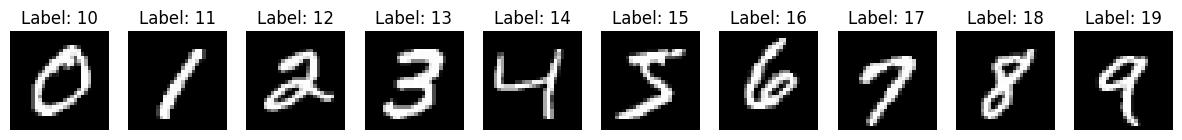

In [ ]:
# dataFashion = Preprocessing(fileFashionTrainName, fileFashionTrainLabelName, fileFashionTestName, fileFashionTestLabelName, 0)
dataMnist = Preprocessing(fileMNISTTrainName, fileMNISTTrainLabelName, fileMNISTTestName, fileMNISTTestLabelName, 1)
# trainFashionLoader, testFashionLoader = dataFashion.returnLoaders()
trainMNISTLoader, testMNISTLoader = dataMnist.returnLoaders()
dataMnist.showPictures()

# combineDiscTrain_ds = ConcatDataset([dataFashion.trainLoader.dataset, dataMnist.trainLoader.dataset])
# combineDiscTest_ds = ConcatDataset([dataFashion.testLoader.dataset, dataMnist.testLoader.dataset])
# combineDiscTrain_loader = DataLoader(combineDiscTrain_ds, batch_size=100, shuffle=True)
# combineDiscTest_loader = DataLoader(combineDiscTest_ds, batch_size=1000, shuffle=False)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
spaceDim = 64 * 7 * 7

In [5]:
class Encoder(nn.Module):

    def __init__(self, latentDim: int = 20):
        super().__init__()
        self.latentDim = latentDim
        self.encode = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),  # 28→14
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),  # 14→7
            nn.ReLU(inplace=True),
            nn.Flatten(),
        )
        self.fc_mu = nn.Linear(spaceDim, latentDim)
        self.fc_logvar = nn.Linear(spaceDim, latentDim)

    def forward(self, x: torch.Tensor):
        h = self.encode(x)
        return self.fc_mu(h), self.fc_logvar(h)

In [6]:
class Decoder(nn.Module):

    def __init__(self, latentDim):
        super().__init__()
        self.latentDim = latentDim
        self.fc = nn.Linear(latentDim, spaceDim)
        self.decode = nn.Sequential(
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),  # 14×14
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),  # 28×28
        )

    def forward(self, data: torch.Tensor):
        return self.decode(self.fc(data))

In [7]:
import math

# notes: p(z) ~ N(0,1)
# p_teta(x|z) ~ Bernoilu(sigmoid(f_theta(z))) - decoder
# q_phy(z|x) ~ N(mu_phy(x)|var_phy(x)) - encder
# Loss

class VAE(nn.Module):
    def __init__(self, trainLoader: DataLoader, testLoader: DataLoader, latentDim: int = 20, lr: float = 1e-3, epochs: int = 20):
        super().__init__()
        self.device = device
        self.encoder = Encoder(latentDim).to(device)
        self.decoder = Decoder(latentDim).to(device)
        self.trainLoader = trainLoader
        self.testLoader = testLoader
        self.latentDim = latentDim
        self.epochs = epochs
        self.current_epoch = 0
        self.opt_theta = torch.optim.Adam(self.decoder.parameters(), lr=lr)
        self.opt_phi = torch.optim.Adam(self.encoder.parameters(), lr=lr)
        self.historyTrain = []
        self.historyTest = []

    def gradByCrossEntr(self, x, f_x):
        return (-x/f_x + (1 - x)/(1 - f_x))/x.size(0)

    def gradByActivationFunc(self, p):
        return p*(1 - p)

    def reparam(self, mu, logvar) -> torch.Tensor:
        eps = torch.randn_like(mu)
        return mu + eps * (0.5 * logvar).exp()

    def getProbsAndLogits(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparam(mu, logvar)
        logits = self.decoder(z)
        p = torch.sigmoid(logits)
        return logits, p

    # decoder
    def gradByTheta(self, x, k: int = 5):
        params = list(self.decoder.parameters())
        total_grads = [torch.zeros_like(p) for p in params]
        for _ in range(k):
            logits, p = self.getProbsAndLogits(x)
            grad_loss = self.gradByCrossEntr(x, p)
            grad_logits = grad_loss * self.gradByActivationFunc(p) 
            
            grads = torch.autograd.grad(outputs=logits, inputs=params, grad_outputs=grad_logits, retain_graph=False)
            for i, g in enumerate(grads): total_grads[i] += g / k
        return total_grads

    # p(z) ~ N(0, I)
    def _log_p_z(self, z: torch.Tensor) -> torch.Tensor:
        return (-0.5 * (z.pow(2) + math.log(2 * math.pi)).sum(dim = 1)).mean()

    # q(z|x) ~ N(mu, var)
    def _log_normal(self, z, mu, logvar):
        return (-0.5 * (logvar + (z - mu).pow(2)/logvar.exp() + math.log(2 * math.pi)).sum(dim = 1)).mean()

    # encoder
    def gradByPhi(self, x: torch.Tensor, k: int = 5):
        params = list(self.encoder.parameters())
        total_grads = [torch.zeros_like(p) for p in params]

        for _ in range(k):
            mu, logvar = self.encoder(x)
            z = self.reparam(mu, logvar)
            logits = self.decoder(z)

            # logp(x,z)
            log_p_x_z = -self.reconstrLossBern(logits, x) 
            log_p_z = self._log_p_z(z) 
            
            # logq(z|x)
            log_q_z_x = self._log_normal(z, mu, logvar) 

            innerSum = -(log_p_x_z + log_p_z - log_q_z_x)

            grads = torch.autograd.grad(outputs=innerSum, inputs=params, retain_graph = False)
            for i, g in enumerate(grads): total_grads[i] += g / k
        return total_grads

    def forward(self, x: torch.Tensor):
        mu, logvar = self.encoder(x)
        return self.decoder(self.reparam(mu, logvar)), mu, logvar

    def reconstrLossBern(self, recon_logit, x):
        return F.binary_cross_entropy_with_logits(recon_logit, x, reduction="sum")/x.size(0)
    
    # KL divergence between q(z|x) ~ N(mu, var) and p(z) ~ N(0, 1)
    def regLoss(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        return (-0.5*torch.sum(1+logvar-mu.pow(2)-logvar.exp(), dim=1)).mean()

    def _loss(self, recon: torch.Tensor, x: torch.Tensor, mu: torch.Tensor, logvar: torch.Tensor, kld_weight: float = 1):
        lossConstr = self.reconstrLossBern(recon, x)
        lossReg = self.regLoss(mu, logvar)
        return lossConstr + kld_weight * lossReg

    def _run_epoch(self, loader: DataLoader, train: bool, myTrain: bool = True):
        self.train() if train else self.eval()
        total_loss = 0.0

        for x, _ in tqdm(loader, desc = f"{'Train' if train else 'Test'} {self.current_epoch}/{self.epochs}"):
            x = x.to(self.device).float()
            self.opt_theta.zero_grad()
            self.opt_phi.zero_grad()

            if train and myTrain:
                grad_theta = self.gradByTheta(x)
                grad_phi = self.gradByPhi(x)

                for p, g in zip(self.decoder.parameters(), grad_theta): p.grad = g.detach()
                for p, g in zip(self.encoder.parameters(), grad_phi): p.grad = g.detach()

                with torch.no_grad():
                    recon, mu, logvar = self(x)
                    loss = self._loss(recon, x, mu, logvar)
                    
                self.opt_theta.step()
                self.opt_phi.step()
                
            elif train and not myTrain:
                recon, mu, logvar = self(x)
                loss = self._loss(recon, x, mu, logvar)
                loss.backward()
                self.opt_theta.step()
                self.opt_phi.step()
            else:
                with torch.no_grad():
                    recon, mu, logvar = self(x)
                    loss = self._loss(recon, x, mu, logvar)

            total_loss += loss.item() 
        return total_loss / len(loader)

    def fit(self, myTrain):
        for ep in range(1, self.epochs + 1):
            self.current_epoch = ep
            curTrainLoss = self._run_epoch(self.trainLoader, train = True, myTrain = myTrain)
            curTestLoss = self._run_epoch(self.testLoader, train = False)
            self.historyTrain.append(curTrainLoss)
            self.historyTest.append(curTestLoss)
            print(f"Epoch {ep}/{self.epochs}  train: {curTrainLoss:.4f}  test: {curTestLoss:.4f}")

    def plotGraphics(self):
        plt.figure(figsize = (6, 4))
        plt.plot(self.historyTrain, label = "train")
        plt.plot(self.historyTest, label = "test")
        plt.xlabel("epoch")
        plt.ylabel("ELBO")
        plt.title("VAE learning curve")
        plt.legend()
        plt.tight_layout()
        plt.show()

    def plotImages(self, n = 8):
        self.eval()
        x, _ = next(iter(self.testLoader))
        x = x[:n].to(self.device).float()

        with torch.no_grad():
            logits, _, _ = self(x)
            recon = torch.sigmoid(logits)

        fig, axes = plt.subplots(2, n, figsize = (1.5 * n, 3))
        for i in range(n):
            axes[0, i].imshow(x[i].cpu().squeeze(), cmap = "gray")
            axes[0, i].axis("off")
            axes[1, i].imshow(recon[i].cpu().squeeze(), cmap = "gray")
            axes[1, i].axis("off")

        axes[0, 0].set_ylabel("orig")
        axes[1, 0].set_ylabel("recon")
        plt.tight_layout()
        plt.show()


Test 1/15: 100%|██████████| 10/10 [00:00<00:00, 28.27it/s]


Epoch 1/15  train: 269.4507  test: 199.7621


Test 2/15: 100%|██████████| 10/10 [00:00<00:00, 28.03it/s]


Epoch 2/15  train: 184.3434  test: 174.1145


Test 3/15: 100%|██████████| 10/10 [00:00<00:00, 23.88it/s]


Epoch 3/15  train: 169.2901  test: 163.7719


Test 4/15: 100%|██████████| 10/10 [00:00<00:00, 28.02it/s]


Epoch 4/15  train: 161.2401  test: 157.5860


Test 5/15: 100%|██████████| 10/10 [00:00<00:00, 27.99it/s]


Epoch 5/15  train: 156.2666  test: 153.6840


Test 6/15: 100%|██████████| 10/10 [00:00<00:00, 28.00it/s]


Epoch 6/15  train: 153.0259  test: 150.4874


Test 7/15: 100%|██████████| 10/10 [00:00<00:00, 23.87it/s]


Epoch 7/15  train: 150.4983  test: 148.4591


Test 8/15: 100%|██████████| 10/10 [00:00<00:00, 27.86it/s]


Epoch 8/15  train: 148.4239  test: 146.7407


Test 9/15: 100%|██████████| 10/10 [00:00<00:00, 27.86it/s]


Epoch 9/15  train: 146.7588  test: 145.2411


Test 10/15: 100%|██████████| 10/10 [00:00<00:00, 27.90it/s]


Epoch 10/15  train: 145.3817  test: 144.2739


Test 11/15: 100%|██████████| 10/10 [00:00<00:00, 27.73it/s]


Epoch 11/15  train: 144.1978  test: 142.6861


Test 12/15: 100%|██████████| 10/10 [00:00<00:00, 27.82it/s]


Epoch 12/15  train: 143.1623  test: 142.0503


Test 13/15: 100%|██████████| 10/10 [00:00<00:00, 27.97it/s]


Epoch 13/15  train: 142.2047  test: 141.0728


Test 14/15: 100%|██████████| 10/10 [00:00<00:00, 27.83it/s]


Epoch 14/15  train: 141.2873  test: 140.2920


Test 15/15: 100%|██████████| 10/10 [00:00<00:00, 27.92it/s]


Epoch 15/15  train: 140.5220  test: 139.5184


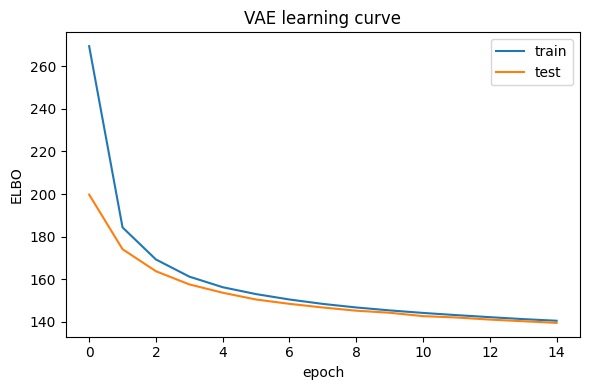

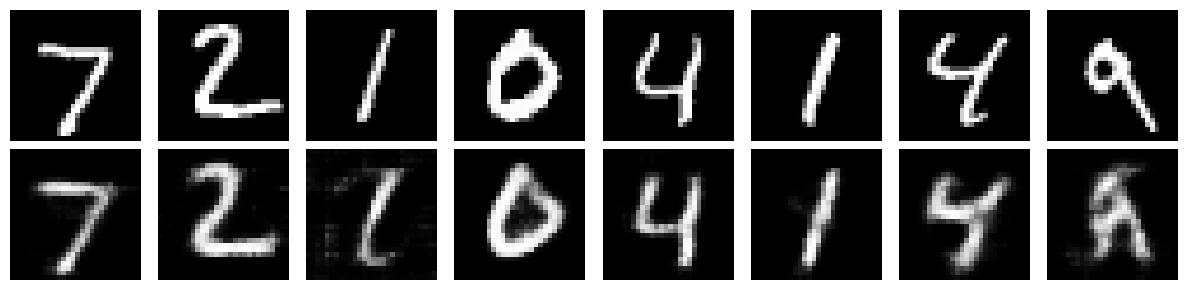

In [8]:
latent_dim = 10000
epochs = 15
lr = 1e-3

vae = VAE(trainMNISTLoader, testMNISTLoader, latentDim=latent_dim, lr=lr, epochs=epochs)
vae.fit(True)
vae.plotGraphics()
vae.plotImages(8)

Test 1/10: 100%|██████████| 10/10 [00:00<00:00, 97.70it/s]


Epoch 1/10  train: 266.0299  test: 186.4667


Test 2/10: 100%|██████████| 10/10 [00:00<00:00, 97.54it/s]


Epoch 2/10  train: 172.6515  test: 162.2330


Test 3/10: 100%|██████████| 10/10 [00:00<00:00, 97.78it/s]


Epoch 3/10  train: 158.2207  test: 153.5496


Test 4/10: 100%|██████████| 10/10 [00:00<00:00, 60.19it/s]


Epoch 4/10  train: 152.3809  test: 149.2856


Test 5/10: 100%|██████████| 10/10 [00:00<00:00, 97.82it/s]


Epoch 5/10  train: 148.4805  test: 146.0697


Test 6/10: 100%|██████████| 10/10 [00:00<00:00, 97.97it/s]


Epoch 6/10  train: 145.7436  test: 143.7228


Test 7/10: 100%|██████████| 10/10 [00:00<00:00, 97.89it/s]


Epoch 7/10  train: 143.4607  test: 141.9702


Test 8/10: 100%|██████████| 10/10 [00:00<00:00, 97.77it/s]


Epoch 8/10  train: 141.1154  test: 139.1426


Test 9/10: 100%|██████████| 10/10 [00:00<00:00, 97.76it/s]


Epoch 9/10  train: 138.0113  test: 135.1574


Test 10/10: 100%|██████████| 10/10 [00:00<00:00, 97.58it/s]

Epoch 10/10  train: 134.1667  test: 131.4521


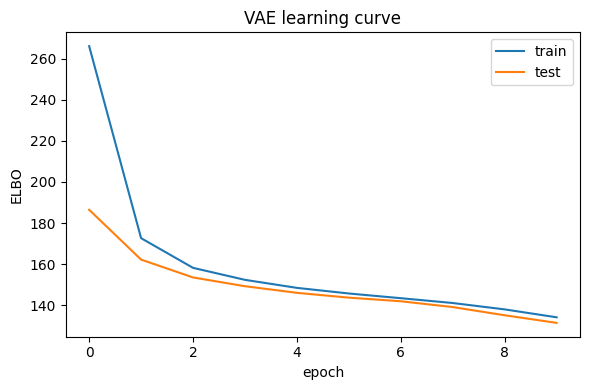

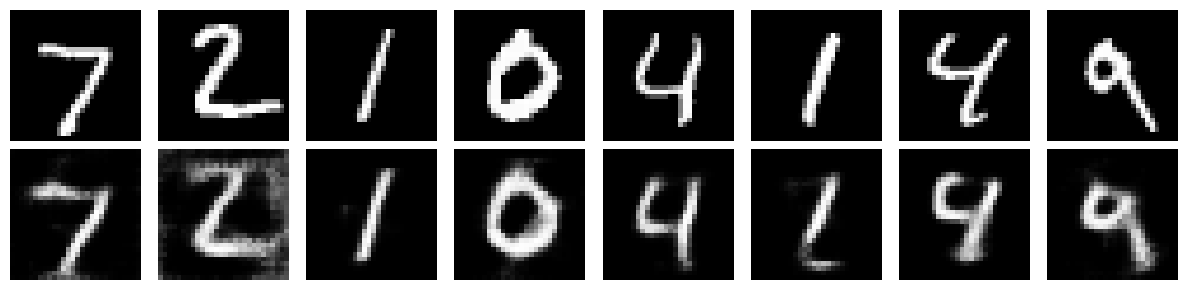

In [9]:
latent_dim = 1000
epochs = 10
lr = 1e-3

vae = VAE(trainMNISTLoader, testMNISTLoader, latentDim=latent_dim, lr=lr, epochs=epochs)
vae.fit(False)
vae.plotGraphics()
vae.plotImages(8)

In [10]:
class Generator(nn.Module):
    def __init__(self, latent_dim: int, n_classes: int, embed_dim: int = 50):
        super().__init__()
        self.latent_dim = latent_dim
        self.embed = nn.Embedding(n_classes, embed_dim)

        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim + embed_dim, 128, 7, 1, 0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(64, 1, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        h = self.embed(y).unsqueeze(2).unsqueeze(3)
        z = z.view(z.size(0), self.latent_dim, 1, 1) 
        x = torch.cat([z, h], dim=1)
        return self.model(x)

In [11]:
class Discriminator(nn.Module):
    def __init__(self, n_classes: int, embed_dim: int = 50):
        super().__init__()
        self.embed = nn.Embedding(n_classes, embed_dim)

        self.model = nn.Sequential(
            nn.Conv2d(1 + embed_dim, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 1, kernel_size=3, stride=1, padding=0, bias=False)
        )

    def forward(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        h = self.embed(y).unsqueeze(2).unsqueeze(3)
        h = h.expand(-1, -1, x.size(2), x.size(3))  
        x = torch.cat([x, h], dim=1)
        return self.model(x).view(-1, 1)  


In [12]:
def dcgan_init(m):
    cls = m.__class__.__name__
    if cls.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif cls.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
from typing import Any, Optional

class CGAN:
    def __init__(self, train_loader, test_loader: Optional[Any] = None, z_dim: int = 100, n_classes: int = 10, lr: float = 2e-4, device: Optional[torch.device] = None):
        self.device = device 
        self.z_dim = z_dim
        self.n_classes = n_classes

        self.Gena = Generator(z_dim, n_classes).apply(dcgan_init).to(self.device)
        self.Discrim = Discriminator(n_classes).apply(dcgan_init).to(self.device)

        self.optGena = optim.Adam(self.Gena.parameters(), lr=2*lr, betas=(0.5, 0.999))
        self.optDisc = optim.Adam(self.Discrim.parameters(), lr=lr, betas=(0.5, 0.999))
        self.crit = nn.BCEWithLogitsLoss()

        self.train_loader = train_loader
        self.test_loader = test_loader

        self.DiscTrain = []
        self.GenaTrain = []
        self.DiscTest = []
        self.GenaTest = []

    @staticmethod
    def _to_minus1_1(imgs: torch.Tensor) -> torch.Tensor:
        # (0,1) → (-1,1)
        return imgs.mul(2.0).sub(1)

    def _sanitize_labels(self, labels: torch.Tensor) -> torch.Tensor:
        return (labels % self.n_classes).long()

    def _d_step(self, real_imgs: torch.Tensor, labels: torch.Tensor):
        real_imgs = self._to_minus1_1(real_imgs)
        labels = self._sanitize_labels(labels)

        real_logits = self.Discrim(real_imgs, labels)
        loss_real = self.crit(real_logits, torch.ones_like(real_logits))

        z = torch.randn(real_imgs.size(0), self.z_dim, device=self.device)
        with torch.no_grad(): fake = self.Gena(z, labels)
        fake_logits = self.Discrim(fake.detach(), labels)
        loss_fake = self.crit(fake_logits, torch.zeros_like(fake_logits))

        discLoss = 0.5 * (loss_real + loss_fake)
        self.optDisc.zero_grad()
        discLoss.backward()
        self.optDisc.step()
        
        return discLoss.item()

    def _g_step(self, labels: torch.Tensor):
        labels = self._sanitize_labels(labels)
        z = torch.randn(labels.size(0), self.z_dim, device=self.device)
        logits = self.Discrim(self.Gena(z, labels), labels)
        genaLoss = 2*self.crit(logits, torch.ones_like(logits))

        self.optGena.zero_grad()
        genaLoss.backward()
        self.optGena.step()
        return genaLoss.item()

    def _run_epoch_train(self):
        self.Gena.train()
        self.Discrim.train()
        discLoss=genaLoss=countBatch=0

        for imgs, labels in tqdm(self.train_loader, desc="  train", leave=False):
            imgs, labels = imgs.to(self.device), labels.to(self.device)
            discLoss += self._d_step(imgs, labels)
            for _ in range(3):
                genaLoss += self._g_step(labels)
            genaLoss /= 3
            countBatch += 1

        return discLoss/countBatch, genaLoss/countBatch

    def _run_epoch_validate(self):
        self.Gena.eval()
        self.Discrim.eval()
        discLoss=genaLoss=countBatch=0

        with torch.no_grad():
            for imgs, labels in tqdm(self.test_loader, desc="  validate", leave=False):
                imgs, labels = imgs.to(self.device), labels.to(self.device)
                imgs = self._to_minus1_1(imgs)
                labels = self._sanitize_labels(labels)

                realLogits = self.Discrim(imgs, labels)
                loss_real = self.crit(realLogits, torch.ones_like(realLogits))

                z = torch.randn(imgs.size(0), self.z_dim, device=self.device)
                fake = self.Gena(z, labels)
                fakeLogits = self.Discrim(fake, labels)
                loss_fake = self.crit(fakeLogits, torch.zeros_like(fakeLogits))

                discLoss += 0.5 * (loss_real + loss_fake).item()
                genaLoss += self.crit(fakeLogits, torch.ones_like(fakeLogits)).item()
                countBatch += 1

        return discLoss/countBatch, genaLoss/countBatch

    def fit(self, epochs: int = 50) -> None:
        for curEpoch in range(1, epochs + 1):
            discTrain, genaTrain = self._run_epoch_train()
            self.DiscTrain.append(discTrain)
            self.GenaTrain.append(genaTrain)
            genaLoss = f"Epoch {curEpoch}: D_tr={discTrain:.4f} | G_tr={genaTrain:.4f}"

            discVal, genVal = self._run_epoch_validate()
            self.DiscTest.append(discVal)
            self.GenaTest.append(genVal)
            genaLoss += f" || D_val={discVal:.4f} | G_val={genVal:.4f}"

            print(genaLoss)

    def plot_losses(self) -> None:
        epochs = range(1, len(self.DiscTrain)+1)
        plt.figure(figsize=(6,4))
        plt.plot(epochs, self.DiscTrain, 'b-', label='D train')
        plt.plot(epochs, self.GenaTrain, 'r-', label='G train')
        if self.DiscTest:
            plt.plot(epochs, self.DiscTest, 'b--', label='D val')
            plt.plot(epochs, self.GenaTest, 'r--', label='G val')
        plt.xlabel('epoch'); plt.ylabel('loss'); plt.legend(); plt.tight_layout(); plt.show()
        

    def plotImages(self, n: int = 8) -> None:
        self.Gena.eval()
        imgs, labels = next(iter(self.test_loader))
        imgs, labels = imgs[:n].to(self.device).float(), labels[:n].to(self.device)
        labels = self._sanitize_labels(labels)

        with torch.no_grad():
            z = torch.randn(n, self.z_dim, device=self.device)
            fakes = self.Gena(z, labels)            
            fakes = (fakes + 1) / 2                   

        _, axes = plt.subplots(2, n, figsize=(1.5 * n, 3))
        for i in range(n):
            axes[0, i].imshow(imgs[i].cpu().squeeze(), cmap='gray')
            axes[0, i].axis('off')
            axes[1, i].imshow(fakes[i].cpu().squeeze(), cmap='gray')
            axes[1, i].axis('off')

        axes[0, 0].set_ylabel('real')
        axes[1, 0].set_ylabel('fake')
        plt.tight_layout()
        plt.show()



In [14]:
model_mnist = CGAN(trainMNISTLoader, testMNISTLoader, z_dim=1000, n_classes=10, lr=1e-3, device=device)
model_mnist.fit(7)

  train:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 001: D_tr=0.7355 | G_tr=1.4838 || D_val=0.6968 | G_val=0.6933


Epoch 002: D_tr=0.6987 | G_tr=1.3934 || D_val=0.6956 | G_val=0.6855


Epoch 003: D_tr=0.6952 | G_tr=1.3892 || D_val=0.6965 | G_val=0.7124


Epoch 004: D_tr=0.6953 | G_tr=1.3892 || D_val=0.6951 | G_val=0.7105


Epoch 005: D_tr=0.6953 | G_tr=1.3899 || D_val=0.6944 | G_val=0.7274


Epoch 006: D_tr=0.6941 | G_tr=1.3867 || D_val=0.6941 | G_val=0.6829


Epoch 007: D_tr=0.6960 | G_tr=1.3918 || D_val=0.6935 | G_val=0.6817


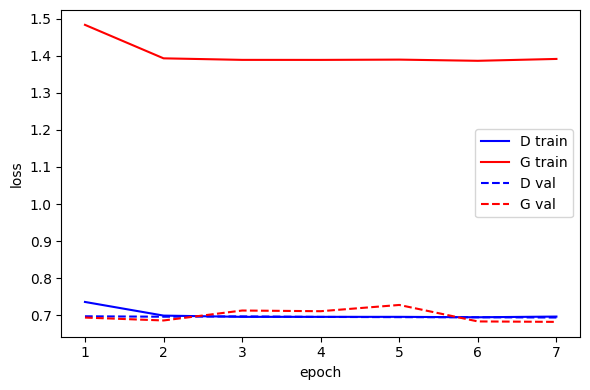

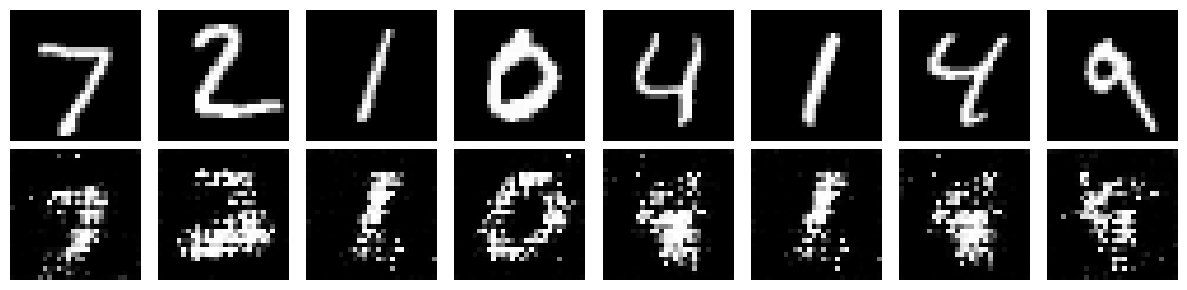

In [15]:
model_mnist.plot_losses()
model_mnist.plotImages(8)

In [ ]:
from denoising_diffusion_pytorch import Unet

class DiffusionModel(nn.Module):
    def __init__(self, trainLoader, testLoader, timeStep, betaStart, betaEnd, typeBuild, device, prediction_type="noise", lr=1e-4):
        super().__init__()
        self.trainLoader = trainLoader
        self.testLoader = testLoader
        self.betaStart = betaStart
        self.betaEnd = betaEnd
        self.typeBuild = typeBuild
        self.timeStep = timeStep
        self.alpha = None
        self.beta = None
        self.alpha_cumprod = None
        self.EPS = 1e-4
        self.lr = lr
        self.device = device
        self.vlb_weight = 0
        self.historyTrainLoss = []
        self.historyTestLoss = []
        self.historyTrainVLB  = []
        self.historyTestVLB = []
        
        self.prediction_type = prediction_type
        
        self.buildShedule(betaStart, betaEnd, typeBuild, timeStep)
        self.sqrt_alpha_cumprod = torch.sqrt(self.alpha_cumprod)
        self.sqrt_one_minus_alpha_cumprod = torch.sqrt(1 - self.alpha_cumprod)
        
        condition = True
        self.model = Unet(dim=16, dim_mults =(1, 2, 4), channels=1, learned_sinusoidal_cond=True, learned_variance=False, self_condition=condition).to(self.device)
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=2e-4, weight_decay=1e-4, betas=(0.9, 0.999))  
          
    def forward(self, batch, timeSteps):
        return self.model(batch, timeSteps)
    
    def train_epoch(self):
        self.model.train()
        total_noise = 0.0
        total_vlb   = 0.0
        for batch, _ in tqdm(self.trainLoader, desc="  train", leave=False):
            batch = batch.to(self.device)
            noise_loss = self.lossNoise(batch)
            vlb_loss = self.lossVLB(batch)
            loss = noise_loss + self.vlb_weight * vlb_loss

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            total_noise += noise_loss.item()
            total_vlb += vlb_loss.item()

        avg_noise = total_noise / len(self.trainLoader)
        avg_vlb = total_vlb / len(self.trainLoader)
        return avg_noise, avg_vlb
            
    def validate_epoch(self):
        self.model.eval()
        total_noise = 0.0
        total_vlb = 0.0
        with torch.no_grad():
            for batch, _ in tqdm(self.testLoader, desc="  valid", leave=False):
                batch = batch.to(self.device)
                noise_loss = self.lossNoise(batch)
                vlb_loss = self.lossVLB(batch)

                total_noise += noise_loss.item()
                total_vlb += vlb_loss.item()
                
        avg_noise = total_noise / len(self.testLoader)
        avg_vlb = total_vlb / len(self.testLoader)
        return avg_noise, avg_vlb

    def fit(self, epochs):
        for epoch in range(1, epochs+1):
            train_noise, train_vlb = self.train_epoch()
            val_noise, val_vlb = self.validate_epoch()

            total_train = train_noise + self.vlb_weight * train_vlb
            total_val = val_noise + self.vlb_weight * val_vlb

            print(f"Epoch {epoch}/{epochs}")
            print(f"Train total: {total_train:.4f}  " f"(noise: {train_noise:.4f}, vlb: {train_vlb:.4f})")
            print(f"Valid total: {total_val:.4f}  " f"(noise: {val_noise:.4f}, vlb: {val_vlb:.4f})")

            self.historyTrainLoss.append(total_train)
            self.historyTestLoss.append(total_val)
            self.historyTrainVLB.append(train_vlb)
            self.historyTestVLB.append(val_vlb)
    
    def sample(self, count):
        x = torch.randn(count, 1, 28, 28, device=self.device)
        for step in range(self.timeStep - 1, -1, -1):
            t = torch.full((count,), step, device=self.device, dtype=torch.long)
            pred = self.model(x, t)

            if self.prediction_type == 'v':
                eps_pred = self.sqrt_one_minus_alpha_cumprod[step]*x + self.sqrt_alpha_cumprod[step]*pred
            else:
                eps_pred = pred

            mean, var = self.predictPosterior(x, eps_pred, t)
            noise = torch.randn_like(x) if step > 0 else 0
        return mean + torch.sqrt(var) * noise
    
    
    def predictPosterior(self, x_t, noisePred, timeSteps):
        beta_t = self.beta[timeSteps].view(-1, 1, 1, 1)
        alpha_t = self.alpha[timeSteps].view(-1, 1, 1, 1)
        sqrt_alpha_cum = self.sqrt_alpha_cumprod[timeSteps].view(-1,1,1,1) 
        sqrt_one_minus_alpha_cumprod = self.sqrt_one_minus_alpha_cumprod[timeSteps].view(-1,1,1,1)

        inverseAlpha = 1/torch.sqrt(alpha_t)
        denom = torch.sqrt(1 - sqrt_alpha_cum)
        numerator= 1-alpha_t
        mean = inverseAlpha * (x_t - (numerator/denom) * noisePred)
        var = beta_t * (1 - sqrt_one_minus_alpha_cumprod)/(1 - sqrt_alpha_cum)
        return mean, var
    
    def buildShedule(self,betaStart, betaEnd, typeBuild, timeStep):
        if typeBuild == 'linear':
            betas = torch.linspace(betaStart, betaEnd, timeStep, dtype=torch.float32, device=self.device)
        else:
            steps = torch.arange(0, timeStep+1, dtype=torch.float64, device=self.device)
            cosSteps = torch.cos((steps/timeStep+self.EPS)/(1+self.EPS)*(math.pi/2))
            alpha = cosSteps/cosSteps[0]
            betas = 1-alpha[1:]/alpha[:-1]
            betas = torch.clamp(betas, 0.0, 0.999).to(torch.float32)
        
        alphas = 1-betas
  
        alpha_cumprod = torch.empty_like(alphas)
        running_prod = torch.tensor(1.0, device=self.device)
        for i in range(timeStep):
            running_prod = running_prod * alphas[i]
            alpha_cumprod[i] = running_prod
            
        self.beta = betas       
        self.alpha = alphas
        self.alpha_cumprod = alpha_cumprod 
                
    def lossVLB(self, batchInput):
        x_t, noise, alpha_bar, noisePred, timeSteps = self.q_sample(batchInput)
        meanTrue, varTrue = self.predictPosterior(x_t, noise, timeSteps)
        meanPred, varPred = self.predictPosterior(x_t, noisePred, timeSteps)
        divergence = 0.5 * ((meanTrue - meanPred) ** 2 / varPred).view(batchInput.size(0), -1).sum(dim=1).mean()
        return divergence
    
    def q_sample(self, batchInput):
        countSamples = batchInput.size(0)
        timesPicked = torch.randint(1, self.timeStep, (countSamples,), device=self.device).long()
        noise = torch.randn_like(batchInput)
        alpha_bar = self.alpha_cumprod[timesPicked].view(countSamples,1,1,1)
        x_t = torch.sqrt(alpha_bar)*batchInput + torch.sqrt(1-alpha_bar)*noise
        predNoise = self.model(x_t, timesPicked)
        return x_t, noise, alpha_bar, predNoise, timesPicked

    def lossNoise(self, batch):
        x_t, noise, alpha_bar, _, t = self.q_sample(batch)
        pred_noise = self.model(x_t, t)

        if self.prediction_type == "noise":
            target = noise
        else:
            a_bar = alpha_bar.sqrt()
            b_bar = (1 - alpha_bar).sqrt()
            target = a_bar * noise - b_bar * batch
            
        return F.mse_loss(pred_noise, target)
    
    def lossMean(self, batch):
        x, _, alpha_bar, predNoise, _ = self.q_sample(batch)
        batchInputPred = (x - torch.sqrt(1 - alpha_bar)*predNoise)/torch.sqrt(alpha_bar)
        return F.mse_loss(batchInputPred, batch)
        
    def plot_history(self):
        plt.figure()
        plt.plot(self.historyTrainLoss, label='Train Loss')
        plt.plot(self.historyTestLoss, label='Test Loss')
        plt.plot(self.historyTrainVLB, label='Train vlb Loss')
        plt.plot(self.historyTestVLB, label='Test vlb Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
    
    def plotImages(self, n=8):
        self.model.eval()
        real, _ = next(iter(self.testLoader))
        real = real[:n].to(self.device)
        with torch.no_grad():
            generated = self.sample(n)
        real = real.cpu()
        generated = generated.cpu()

        _, axes = plt.subplots(2, n, figsize=(1.5 * n, 3))
        for i in range(n):
            axes[0, i].imshow(real[i].squeeze(), cmap='gray')
            axes[0, i].axis('off')
            axes[1, i].imshow(generated[i].squeeze(), cmap='gray')
            axes[1, i].axis('off')
        
        axes[0, 0].set_ylabel('real')
        axes[1, 0].set_ylabel('gen')
        plt.tight_layout()
        plt.show()

In [17]:
diff = DiffusionModel(trainMNISTLoader, testMNISTLoader, timeStep=1000, betaStart=1e-4, betaEnd=0.02, typeBuild='cosine', device=device, prediction_type="noise",lr=1e-4)

diff.fit(epochs=5)           
diff.plot_history()             
diff.plotImages(n=8)   

  train:   0%|          | 0/60 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.12 GiB. GPU 0 has a total capacity of 11.72 GiB of which 85.94 MiB is free. Process 1732 has 104.12 MiB memory in use. Including non-PyTorch memory, this process has 11.27 GiB memory in use. Of the allocated memory 11.07 GiB is allocated by PyTorch, and 60.53 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)